In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('prepro.csv')
df.head()

,"Q1r1 - To begin, what is your age?",QNEW1 - Do you have children living in your home (excluding yourself if you are under 18)?,Q8 - Which of the following media or home entertainment equipment does your household own?-Flat panel television,Q8 - Which of the following media or home entertainment equipment does your household own?-Digital video recorder (DVR),Q8 - Which of the following media or home entertainment equipment does your household own?-Streaming media box or over-the-top box,Q8 - Which of the following media or home entertainment equipment does your household own?-Portable streaming thumb drive/fob,Q8 - Which of the following media or home entertainment equipment does your household own?-Over-the-air digital TV antenna (for free access to network broadcast without pay TV subscription),Q8 - Which of the following media or home entertainment equipment does your household own?-Blu-ray disc player/DVD player,Q8 - Which of the following media or home entertainment equipment does your household own?-Gaming console,Q8 - Which of the following media or home entertainment equipment does your household own?-Portable video game player,...,Q89 - Which of the following is your most frequently used mechanism to get news?_I do not follow the news,Q89 - Which of the following is your most frequently used mechanism to get news?_Magazine,Q89 - Which of the following is your most frequently used mechanism to get news?_News aggregators,Q89 - Which of the following is your most frequently used mechanism to get news?_Online news sites not associated with a traditional news organization,Q89 - Which of the following is your most frequently used mechanism to get news?_Online version of newspapers,Q89 - Which of the following is your most frequently used mechanism to get news?_Print newspapers,Q89 - Which of the following is your most frequently used mechanism to get news?_Radio,Q89 - Which of the following is your most frequently used mechanism to get news?_Social media sites,Q89 - Which of the following is your most frequently used mechanism to get news?_Television news stations,Q89 - Which of the following is your most frequently used mechanism to get news?_Variety/talk shows
0,26.0,1,0,0,0,1,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
1,25.0,1,1,1,0,1,0,1,1,1,...,0,0,0,0,1,0,0,0,0,0
2,28.0,1,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,16.0,1,1,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
4,32.0,1,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,1,0,0


In [2]:
target_col = 'Q29 - You said that you subscribe to home Internet access, how much more would you be willing to pay to receive double your download speed?'

# dropping a column that is extremely correlated with the target column
df.drop(columns="Q26 - Which of the following subscriptions does your household purchase?-Home internet", inplace=True)

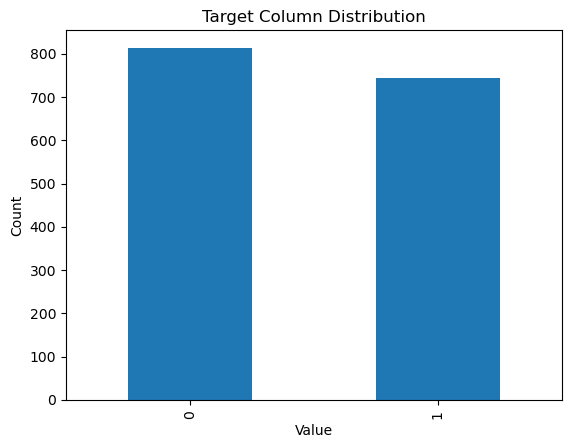

In [3]:
# counting the number of occurrences of each unique value in the target column
counts = df[target_col].value_counts()

# creating a bar plot of the counts
counts.plot(kind='bar')

# setting the plot title and axis labels
plt.title('Target Column Distribution')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

In [4]:
# K-Folds cross-validator. Provides train/test indices to split data in train/test sets. 
# Split dataset into k consecutive folds (without shuffling by default).
# Each fold is then used once as a validation while the k - 1 remaining folds form the training set.

def train_model(X, y, model):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    train_accs = []
    test_accs = []
    predicted_targets = np.array([])
    actual_targets = np.array([])
    
    #predicted_targets = []
    #actual_targets = []

    for fold, (train_index, test_index) in enumerate(kfold.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        train_predictions = model.predict(X_train)
        test_predictions = model.predict(X_test)

        train_acc = accuracy_score(y_train, train_predictions)
        test_acc = accuracy_score(y_test, test_predictions)

        train_accs.append(train_acc)
        test_accs.append(test_acc)

        predicted_targets = np.append(predicted_targets, test_predictions)
        actual_targets = np.append(actual_targets, y_test)

    return train_accs, test_accs, predicted_targets, actual_targets

In [5]:
X = df.drop(target_col, axis=1)
y = df[target_col]

#df.describe()

# Models to consider
models = [
    ("Naive Bayes", GaussianNB()),
    ("Logistic Regression", LogisticRegression()),
    ("SVM", SVC()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Bagging Decision Tree", BaggingClassifier(base_estimator=DecisionTreeClassifier())),
    ("Boosted Decision Tree", AdaBoostClassifier(base_estimator=DecisionTreeClassifier())),
    ("Random Forest", RandomForestClassifier()),
    ("Neural Network", MLPClassifier())
]

# Can consider voting classifier but we skip that 

In [6]:
for name, model in models:

    train_accs, test_accs, predicted_targets, actual_targets = train_model(X, y, model)

    # Calculating the average accuracy over all folds for each model
    train_avg_acc = np.mean(train_accs)
    test_avg_acc = np.mean(test_accs)

    print("\n" + name +  " Accuracy (Train): ", round(train_avg_acc, 2))
    print( name +  " Accuracy (Test): ", round(test_avg_acc,2)) 


Naive Bayes Accuracy (Train):  0.74
Naive Bayes Accuracy (Test):  0.72

Logistic Regression Accuracy (Train):  0.7
Logistic Regression Accuracy (Test):  0.69

SVM Accuracy (Train):  0.57
SVM Accuracy (Test):  0.57

Decision Tree Accuracy (Train):  1.0
Decision Tree Accuracy (Test):  0.66

Bagging Decision Tree Accuracy (Train):  0.98
Bagging Decision Tree Accuracy (Test):  0.71

Boosted Decision Tree Accuracy (Train):  1.0
Boosted Decision Tree Accuracy (Test):  0.67

Random Forest Accuracy (Train):  1.0
Random Forest Accuracy (Test):  0.74

Neural Network Accuracy (Train):  0.79
Neural Network Accuracy (Test):  0.64


Precision:  0.7077131258457375
Recall:  0.7029569892473119
F1 score:  0.7053270397842212


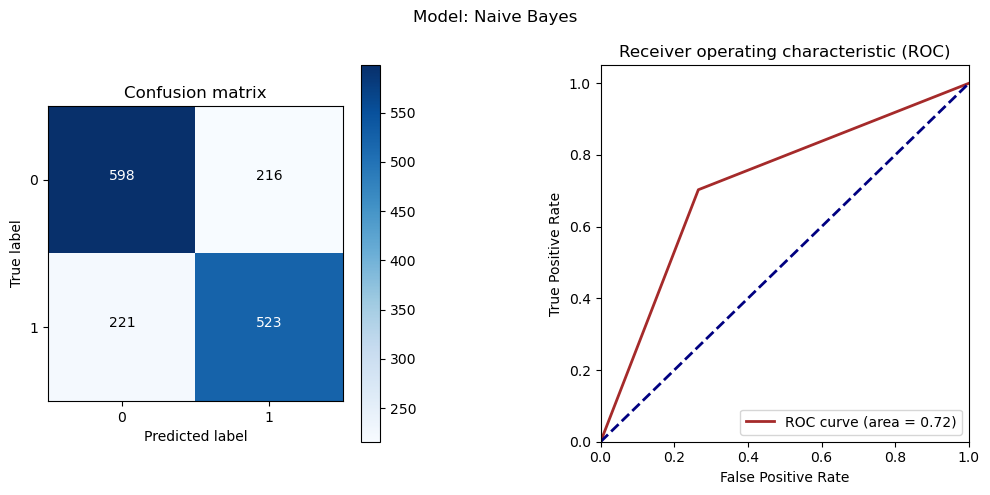

In [7]:
class_names = [0, 1]
train_accs, test_accs, predicted_targets, actual_targets  = train_model(X, y, models[0][1])
cm = confusion_matrix(actual_targets, predicted_targets)

classes = [0,1]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# plotting confusion matrix
im = ax[0].imshow(cm, cmap=plt.get_cmap('Blues'))
ax[0].set_title("Confusion matrix")
fig.colorbar(im, ax=ax[0])

tick_marks = np.arange(len(classes))
ax[0].set_xticks(tick_marks)
ax[0].set_xticklabels(classes)
ax[0].set_yticks(tick_marks)
ax[0].set_yticklabels(classes)
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')

fmt = 'd'
thresh = cm.max() / 2.

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax[0].text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

# Calculating precision, recall, and F1 score, AUC-ROC score
precision = precision_score(actual_targets, predicted_targets)
recall = recall_score(actual_targets, predicted_targets)
f1 = f1_score(actual_targets, predicted_targets)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1)

# plotting ROC curve
# Use different thresholds. pred. prob >0.6,0.7,0.8 and then join dots in x-y plane

fpr, tpr, _ = roc_curve(actual_targets, predicted_targets)
roc_auc = auc(fpr, tpr)

ax[1].plot(fpr, tpr, color='brown', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver operating characteristic (ROC)')
ax[1].legend(loc="lower right")

plt.suptitle("Model: Naive Bayes")
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.show()

In [8]:
df = df[df != -999].dropna()

# Selecting only those customers that are willing to pay
df = df[df[target_col] == 1]
df.head()

,"Q1r1 - To begin, what is your age?",QNEW1 - Do you have children living in your home (excluding yourself if you are under 18)?,Q8 - Which of the following media or home entertainment equipment does your household own?-Flat panel television,Q8 - Which of the following media or home entertainment equipment does your household own?-Digital video recorder (DVR),Q8 - Which of the following media or home entertainment equipment does your household own?-Streaming media box or over-the-top box,Q8 - Which of the following media or home entertainment equipment does your household own?-Portable streaming thumb drive/fob,Q8 - Which of the following media or home entertainment equipment does your household own?-Over-the-air digital TV antenna (for free access to network broadcast without pay TV subscription),Q8 - Which of the following media or home entertainment equipment does your household own?-Blu-ray disc player/DVD player,Q8 - Which of the following media or home entertainment equipment does your household own?-Gaming console,Q8 - Which of the following media or home entertainment equipment does your household own?-Portable video game player,...,Q89 - Which of the following is your most frequently used mechanism to get news?_I do not follow the news,Q89 - Which of the following is your most frequently used mechanism to get news?_Magazine,Q89 - Which of the following is your most frequently used mechanism to get news?_News aggregators,Q89 - Which of the following is your most frequently used mechanism to get news?_Online news sites not associated with a traditional news organization,Q89 - Which of the following is your most frequently used mechanism to get news?_Online version of newspapers,Q89 - Which of the following is your most frequently used mechanism to get news?_Print newspapers,Q89 - Which of the following is your most frequently used mechanism to get news?_Radio,Q89 - Which of the following is your most frequently used mechanism to get news?_Social media sites,Q89 - Which of the following is your most frequently used mechanism to get news?_Television news stations,Q89 - Which of the following is your most frequently used mechanism to get news?_Variety/talk shows
0,26.0,1,0,0,0,1,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
1,25.0,1,1,1,0,1,0,1,1,1,...,0,0,0,0,1,0,0,0,0,0
2,28.0,1,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,32.0,1,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,1,0,0
5,38.0,1,0,1,0,0,1,1,1,0,...,0,0,0,0,0,1,0,0,0,0


In [9]:
#pd.set_option('display.max_columns', 360)
#df.head()

We now perform PCA to reduce number of features and then try the k-means clustering algorithm


In [10]:
pca = PCA(n_components=4)
pca.fit(df)
pca_scores = pca.transform(df)
print(pca.explained_variance_ratio_)

[0.53945904 0.12600823 0.07683586 0.06836291]


In [11]:
#df.isna().sum()
#print(df.isnull().any())
#df.groupby('user_id').apply(lambda column: column.sum()/(column != 0).sum())
#df.dtypes
#df.astype(bool).sum(axis=0)
#s = df.sum()
#s.
#df[s.sort_values(ascending=False).index[:2]]
#grouped = df.sum().reset_index()
#grouped.sort_values(ascending=False)
#df.groupby('group')['id'].count().sort_values(ascending=False)

The scikit-learn version is 1.2.2.
For n_clusters =  2 , the average silhouette_score is:  0.4564126707747321
For n_clusters =  3 , the average silhouette_score is:  0.3862035619148229
For n_clusters =  4 , the average silhouette_score is:  0.3798986235103311


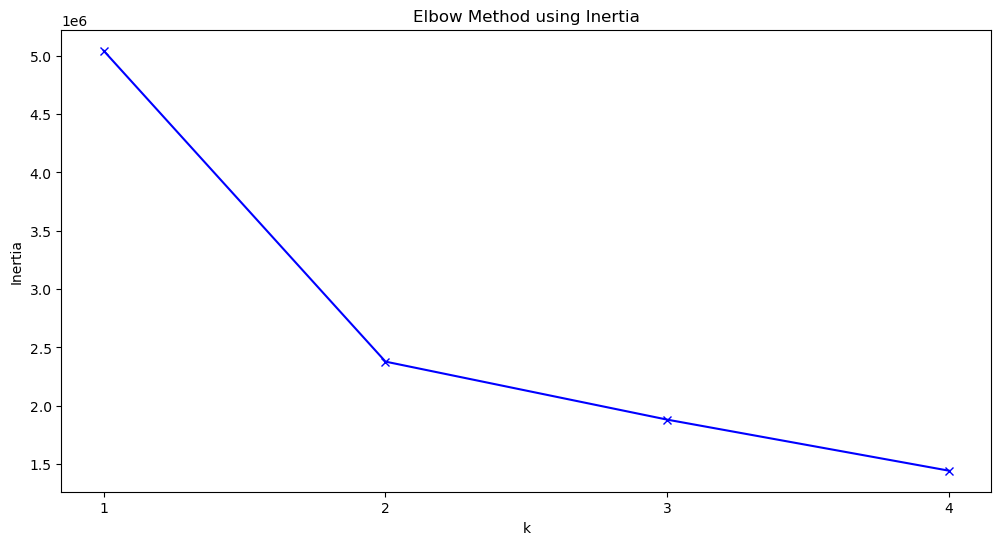

In [12]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
#print('Threadpoolctl version is {}.'.format(threadpoolctl.__version__))



inertias = [] 

for n_clusters in range(1, 5):

    # Elbow method
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state= 11)
    kmeans.fit(pca_scores)
    labels = kmeans.labels_ 
    inertias.append(kmeans.inertia_) 

    # Silhouette analysis
    if n_clusters!=1:

        # calculating the overall silhouette score
        silhouette_avg = silhouette_score(pca_scores, kmeans.labels_)

        print(
        "For n_clusters = ", n_clusters, ", the average silhouette_score is: ", silhouette_avg)

# plotting Elbow method using Inertia
plt.figure(figsize=(12,6))
plt.plot(range(1, 5), inertias, 'bx-',color='blue') 
plt.xlabel('k') 
plt.ylabel('Inertia') 
plt.xticks(range(1, 5))
plt.title('Elbow Method using Inertia') 
plt.show()